In [53]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

In [54]:
class_name = 'Occupancy'
df1 = pd.read_csv('datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df2 =pd.read_csv('datatest.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df3=pd.read_csv('datatest2.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df4=pd.merge(df1, df2, how='outer')
df=pd.merge(df4, df3, how='outer')

In [55]:
df['Day']=pd.to_datetime(df['date']).dt.day
df['Hour']=pd.to_datetime(df['date']).dt.hour
df['Month']=pd.to_datetime(df['date']).dt.month
df['Year']=pd.to_datetime(df['date']).dt.year
df['Data']=pd.to_datetime(df['date']).dt.normalize()
del df['date']

In [56]:
df['Day']=df['Data'].dt.dayofweek
df.drop(['Year','Month','Data'], axis='columns', inplace=True)
del df['HumidityRatio']

In [57]:
from data_preparation import prepare_dataset

In [58]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

In [59]:
df[class_name].value_counts(),df[class_name].value_counts(normalize=True)

(0    15810
 1     4750
 Name: Occupancy, dtype: int64,
 0    0.768969
 1    0.231031
 Name: Occupancy, dtype: float64)

In [60]:
rows2remove = np.random.choice(df[df[class_name] == 1].index, 4750-160, replace=False)

In [61]:
len(df), len(rows2remove)

(20560, 4590)

In [62]:
df2 = df.drop(index=rows2remove, axis=0)
print(len(df2))

15970


In [63]:
print('Dataset shape %s' % Counter(df2[class_name])),df2[class_name].value_counts(normalize=True)

Dataset shape Counter({0: 15810, 1: 160})


(None,
 0    0.989981
 1    0.010019
 Name: Occupancy, dtype: float64)

Split dataset

In [64]:
from sklearn.model_selection import train_test_split, cross_val_score ,cross_val_predict

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [65]:
attributes = [col for col in df.columns if col != class_name]
X = df2[attributes].values
y = df2[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [66]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1], dtype=int64), array([11067,   112], dtype=int64)),
 (array([0, 1], dtype=int64), array([4743,   48], dtype=int64)))

NAIVE

In [67]:
from sklearn.naive_bayes import GaussianNB

In [68]:
naive = GaussianNB()
naive.fit(X_train, y_train)
y_pred0naive = naive.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0naive))
print('F1-score %s' % f1_score(y_test, y_pred0naive, average=None))
print(classification_report(y_test, y_pred0naive))

Accuracy 0.9822584011688583
F1-score [0.99095841 0.53038674]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4743
           1       0.36      1.00      0.53        48

    accuracy                           0.98      4791
   macro avg       0.68      0.99      0.76      4791
weighted avg       0.99      0.98      0.99      4791



 KNN

In [69]:
from sklearn.neighbors import KNeighborsClassifier

In [70]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)
y_pred0knn = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0knn))
print('F1-score %s' % f1_score(y_test, y_pred0knn, average=None))
print(classification_report(y_test, y_pred0knn))

Accuracy 0.9933208098518055
F1-score [0.99663229 0.6       ]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4743
           1       0.75      0.50      0.60        48

    accuracy                           0.99      4791
   macro avg       0.87      0.75      0.80      4791
weighted avg       0.99      0.99      0.99      4791



Logistic regression

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
logis = LogisticRegression(random_state=0)
logis.fit(X_train, y_train)
y_pred0logis = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0logis))
print('F1-score %s' % f1_score(y_test, y_pred0logis, average=None))
print(classification_report(y_test, y_pred0logis))

Accuracy 0.9933208098518055
F1-score [0.99663229 0.6       ]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4743
           1       0.75      0.50      0.60        48

    accuracy                           0.99      4791
   macro avg       0.87      0.75      0.80      4791
weighted avg       0.99      0.99      0.99      4791



Decision tree

In [73]:
from sklearn.tree import DecisionTreeClassifier

In [74]:
tree=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree.fit(X_train,y_train)
y_pred0tree = tree.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0tree))
print('F1-score %s' % f1_score(y_test, y_pred0tree, average=None))
print(classification_report(y_test, y_pred0tree))

Accuracy 0.9968691296180339
F1-score [0.99841889 0.84210526]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4743
           1       0.85      0.83      0.84        48

    accuracy                           1.00      4791
   macro avg       0.92      0.92      0.92      4791
weighted avg       1.00      1.00      1.00      4791



ROC CURVE EVALUATION "operating point" (decisiontree e knn i peggiori)

In [75]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

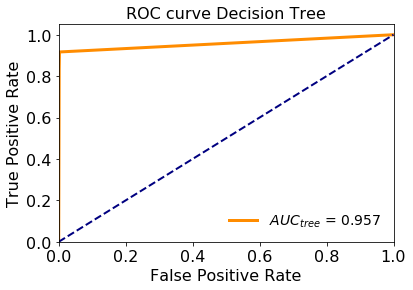

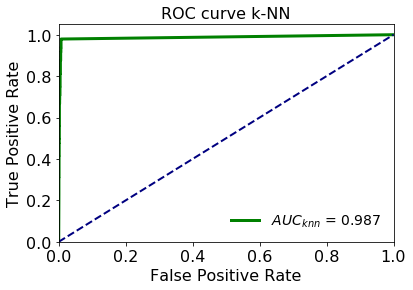

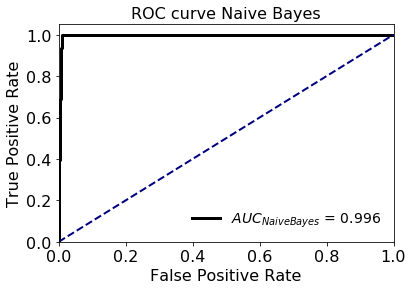

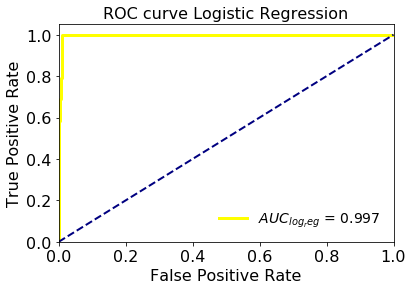

In [76]:
y_scoretree = tree.predict_proba(X_test)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_scoretree[:, 1])
roc_auc_tree = auc(fpr_tree, tpr_tree) 

plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=3, label='$AUC_{tree}$ = %.3f' % (roc_auc_tree))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve Decision Tree', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

y_scoreknn = knn.predict_proba(X_test)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_scoreknn[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.plot(fpr_knn, tpr_knn, color='green', lw=3, label='$AUC_{knn}$ = %.3f' % (roc_auc_knn))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve k-NN', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

y_scorenaive = naive.predict_proba(X_test)
fpr_naive, tpr_naive, _ = roc_curve(y_test, y_scorenaive[:, 1])
roc_auc_naive = auc(fpr_naive, tpr_naive)

plt.plot(fpr_naive, tpr_naive, color='black', lw=3, label='$AUC_{Naive Bayes}$ = %.3f' % (roc_auc_naive))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve Naive Bayes', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

y_scorelogis = logis.predict_proba(X_test)
fpr_logis, tpr_logis, _ = roc_curve(y_test, y_scorelogis[:, 1])
roc_auc_logis = auc(fpr_logis, tpr_logis)

plt.plot(fpr_logis, tpr_logis, color='yellow', lw=3, label='$AUC_{log_reg}$ = %.3f' % (roc_auc_logis))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve Logistic Regression', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


## ADJUST DECISION THRESHOLD for decision tree

Accuracy 0.9906073888541015
F1-score [0.99523356 0.68085106]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.52      1.00      0.68        48

    accuracy                           0.99      4791
   macro avg       0.76      1.00      0.84      4791
weighted avg       1.00      0.99      0.99      4791



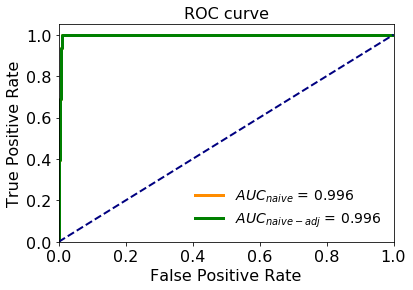

Accuracy 0.9968691296180339
F1-score [0.99841889 0.84210526]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4743
           1       0.85      0.83      0.84        48

    accuracy                           1.00      4791
   macro avg       0.92      0.92      0.92      4791
weighted avg       1.00      1.00      1.00      4791



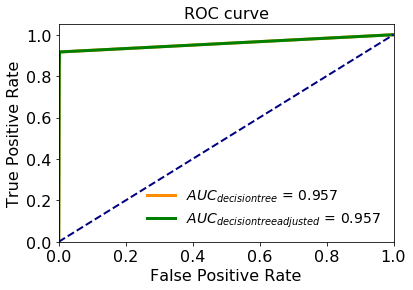

Accuracy 0.9924859110832811
F1-score [0.99621531 0.48571429]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4743
           1       0.77      0.35      0.49        48

    accuracy                           0.99      4791
   macro avg       0.88      0.68      0.74      4791
weighted avg       0.99      0.99      0.99      4791



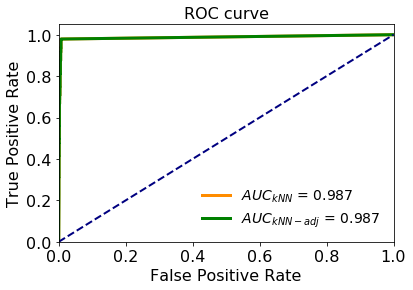

Accuracy 0.99227718639115
F1-score [0.99610895 0.49315068]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4743
           1       0.72      0.38      0.49        48

    accuracy                           0.99      4791
   macro avg       0.86      0.69      0.74      4791
weighted avg       0.99      0.99      0.99      4791



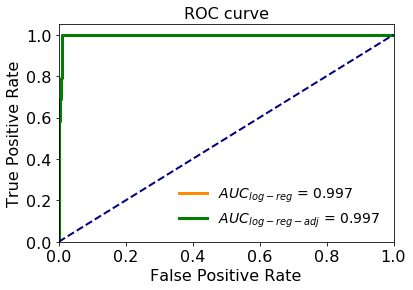

In [152]:
clf = GaussianNB()
clf.fit(X_train, y_train)

def adjusted_predict(X, thr):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

y_pred = adjusted_predict(X_test, thr=0.9)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr_naive, tpr_naive, color='darkorange', lw=3, label='$AUC_{naive}$ = %.3f' % (roc_auc_naive))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_{naive-adj}$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

clf1 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
clf1.fit(X_train, y_train)

def adjusted_predict1(X, thr):
    y_score1 = clf1.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score1])

y_pred1 = adjusted_predict1(X_test, thr=0.9)

print('Accuracy %s' % accuracy_score(y_test, y_pred1))
print('F1-score %s' % f1_score(y_test, y_pred1, average=None))
print(classification_report(y_test, y_pred1))

y_score1 = clf1.predict_proba(X_test)
fpr1, tpr1, thr1 = roc_curve(y_test, y_score1[:, 1])
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=3, label='$AUC_{decision tree}$ = %.3f' % (roc_auc_tree))
plt.plot(fpr1, tpr1, color='green', lw=3, label='$AUC_{decision tree adjusted}$ = %.3f' % (roc_auc1))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


clf2 = KNeighborsClassifier(n_neighbors=10, weights='distance')
clf2.fit(X_train, y_train)

def adjusted_predict2(X, thr):
    y_score2 = clf2.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score2])

y_pred2 = adjusted_predict2(X_test, thr=0.8)

print('Accuracy %s' % accuracy_score(y_test, y_pred2))
print('F1-score %s' % f1_score(y_test, y_pred2, average=None))
print(classification_report(y_test, y_pred2))

y_score2 = clf2.predict_proba(X_test)
fpr2, tpr2, thr2 = roc_curve(y_test, y_score2[:, 1])
roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=3, label='$AUC_{kNN}$ = %.3f' % (roc_auc_knn))
plt.plot(fpr2, tpr2, color='green', lw=3, label='$AUC_{kNN-adj}$ = %.3f' % (roc_auc2))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


clf3 = LogisticRegression(random_state=0)
clf3.fit(X_train, y_train)

def adjusted_predict3(X, thr):
    y_score3 = clf3.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score3])

y_pred3 = adjusted_predict3(X_test, thr=0.6)

print('Accuracy %s' % accuracy_score(y_test, y_pred3))
print('F1-score %s' % f1_score(y_test, y_pred3, average=None))
print(classification_report(y_test, y_pred3))

y_score3 = clf3.predict_proba(X_test)
fpr3, tpr3, thr3 = roc_curve(y_test, y_score3[:, 1])
roc_auc3 = auc(fpr3, tpr3)

plt.plot(fpr_logis, tpr_logis, color='darkorange', lw=3, label='$AUC_{log-reg}$ = %.3f' % (roc_auc_logis))
plt.plot(fpr3, tpr3, color='green', lw=3, label='$AUC_{log-reg-adj}$ = %.3f' % (roc_auc3))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


PCA

In [78]:
from sklearn.decomposition import PCA

In [79]:
X_train.shape

(11179, 6)

In [80]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

In [81]:
X_pca.shape

(11179, 2)

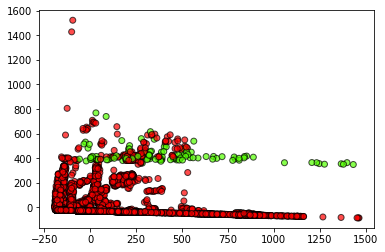

In [82]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

## UNDERSAMPLING

In [83]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

RANDOM UNDERSAMPLER

In [84]:
rus = RandomUnderSampler(random_state=0)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 112, 1: 112})


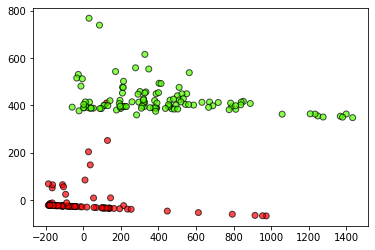

In [85]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

VALUTIAMO IL CLASSIFICATORE DOPO AVER APPORTATO MODIFICHE AL DATASET ATTRAVERSO IL PCA, QUINDI ORA X_train=X_res e y_test=y_res

Accuracy 0.9544980171154247
F1-score [0.9764782  0.30573248]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      4743
           1       0.18      1.00      0.31        48

    accuracy                           0.95      4791
   macro avg       0.59      0.98      0.64      4791
weighted avg       0.99      0.95      0.97      4791



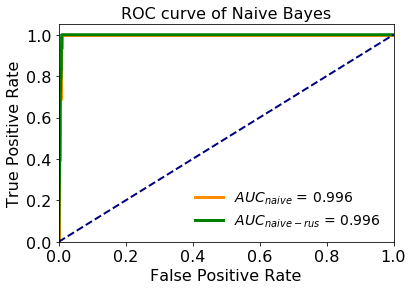

In [86]:
naive = GaussianNB()
naive.fit(X_res, y_res)
y_pred0naive_rus = naive.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0naive_rus))
print('F1-score %s' % f1_score(y_test, y_pred0naive_rus, average=None))
print(classification_report(y_test, y_pred0naive_rus))

y_scorenaive_rus = naive.predict_proba(X_test)
fpr_naive_rus, tpr_naive_rus, _ = roc_curve(y_test, y_scorenaive_rus[:, 1])
roc_auc_naive_rus = auc(fpr_naive_rus, tpr_naive_rus)

plt.plot(fpr_naive, tpr_naive, color='darkorange', lw=3, label='$AUC_{naive}$ = %.3f' % (roc_auc_naive))
plt.plot(fpr_naive_rus, tpr_naive_rus, color='green', lw=3, label='$AUC_{naive-rus}$ = %.3f' % (roc_auc_naive_rus))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Naive Bayes', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9845543727823002
F1-score [0.9921377  0.56470588]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4743
           1       0.39      1.00      0.56        48

    accuracy                           0.98      4791
   macro avg       0.70      0.99      0.78      4791
weighted avg       0.99      0.98      0.99      4791



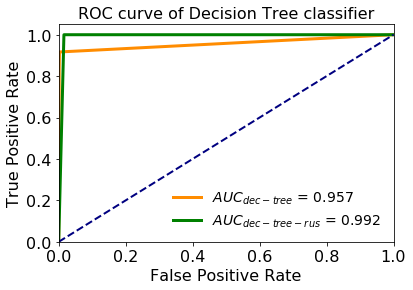

In [87]:
tree=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree.fit(X_res,y_res)
y_pred0tree_rus = tree.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0tree_rus))
print('F1-score %s' % f1_score(y_test, y_pred0tree_rus, average=None))
print(classification_report(y_test, y_pred0tree_rus))

y_scoretree_rus = tree.predict_proba(X_test)
fpr_tree_rus, tpr_tree_rus, _ = roc_curve(y_test, y_scoretree_rus[:, 1])
roc_auc_tree_rus = auc(fpr_tree_rus, tpr_tree_rus) 

plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=3, label='$AUC_{dec-tree}$ = %.3f' % (roc_auc_tree))
plt.plot(fpr_tree_rus, tpr_tree_rus, color='green', lw=3, label='$AUC_{dec-tree-rus}$ = %.3f' % (roc_auc_tree_rus))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Decision Tree classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

C:\Users\Gianmarco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy 0.9837194740137758
F1-score [0.99170918 0.55172414]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4743
           1       0.38      1.00      0.55        48

    accuracy                           0.98      4791
   macro avg       0.69      0.99      0.77      4791
weighted avg       0.99      0.98      0.99      4791



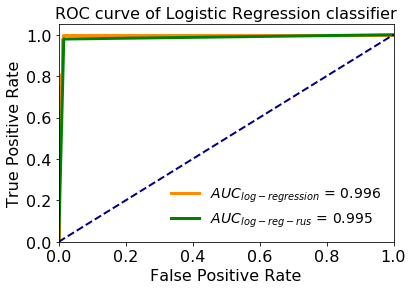

In [36]:
logis= LogisticRegression(random_state=0)
logis.fit(X_res,y_res)
y_pred0logis_rus = logis.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0logis_rus))
print('F1-score %s' % f1_score(y_test, y_pred0logis_rus, average=None))
print(classification_report(y_test, y_pred0logis_rus))

y_scorelogis_rus = logis.predict_proba(X_test)
fpr_logis_rus, tpr_logis_rus, _ = roc_curve(y_test, y_scorelogis_rus[:, 1])
roc_auc_logis_rus = auc(fpr_logis_rus, tpr_logis_rus) 

plt.plot(fpr_logis, tpr_logis, color='darkorange', lw=3, label='$AUC_{log-regression}$ = %.3f' % (roc_auc_logis))
plt.plot(fpr_tree_rus, tpr_tree_rus, color='green', lw=3, label='$AUC_{log-reg-rus}$ = %.3f' % (roc_auc_logis_rus))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Logistic Regression classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9666040492590273
F1-score [0.98284366 0.375     ]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4743
           1       0.23      1.00      0.38        48

    accuracy                           0.97      4791
   macro avg       0.62      0.98      0.68      4791
weighted avg       0.99      0.97      0.98      4791



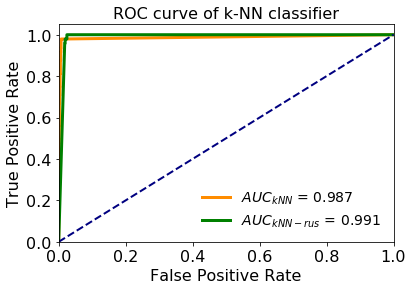

In [88]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_res, y_res)
y_pred0knn_rus = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0knn_rus))
print('F1-score %s' % f1_score(y_test, y_pred0knn_rus, average=None))
print(classification_report(y_test, y_pred0knn_rus))

y_scoreknn_rus = knn.predict_proba(X_test)
fpr_knn_rus, tpr_knn_rus, _ = roc_curve(y_test, y_scoreknn_rus[:, 1])
roc_auc_knn_rus = auc(fpr_knn_rus, tpr_knn_rus)

plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=3, label='$AUC_{kNN}$ = %.3f' % (roc_auc_knn))
plt.plot(fpr_knn_rus, tpr_knn_rus, color='green', lw=3, label='$AUC_{kNN-rus}$ = %.3f' % (roc_auc_knn_rus))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of k-NN classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

per log e naive la roc curve non migliora,mentre per decision tree e knn la roc curve migliora ma
l'accuracy diminuisce leggermente

CONDENSED NEAREST NEIGHBOUR

In [89]:
import warnings
warnings.simplefilter("ignore")

In [90]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 112, 0: 57})


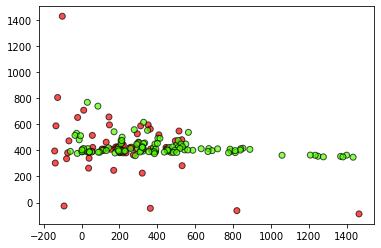

In [91]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9903986641619703
F1-score [0.99514153 0.59649123]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.52      0.71      0.60        48

    accuracy                           0.99      4791
   macro avg       0.76      0.85      0.80      4791
weighted avg       0.99      0.99      0.99      4791



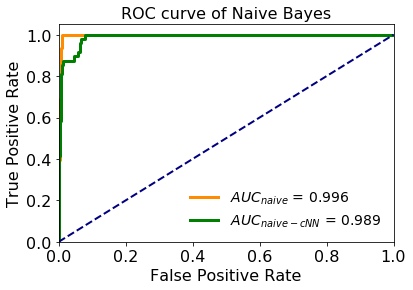

In [92]:
naive = GaussianNB()
naive.fit(X_res, y_res)
y_pred0naive_rus = naive.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0naive_rus))
print('F1-score %s' % f1_score(y_test, y_pred0naive_rus, average=None))
print(classification_report(y_test, y_pred0naive_rus))

y_scorenaive_rus = naive.predict_proba(X_test)
fpr_naive_rus, tpr_naive_rus, _ = roc_curve(y_test, y_scorenaive_rus[:, 1])
roc_auc_naive_rus = auc(fpr_naive_rus, tpr_naive_rus)

plt.plot(fpr_naive, tpr_naive, color='darkorange', lw=3, label='$AUC_{naive}$ = %.3f' % (roc_auc_naive))
plt.plot(fpr_naive_rus, tpr_naive_rus, color='green', lw=3, label='$AUC_{naive-cNN}$ = %.3f' % (roc_auc_naive_rus))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Naive Bayes', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.7372156126069714
F1-score [0.84748637 0.05124341]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      4743
           1       0.03      0.71      0.05        48

    accuracy                           0.74      4791
   macro avg       0.51      0.72      0.45      4791
weighted avg       0.99      0.74      0.84      4791



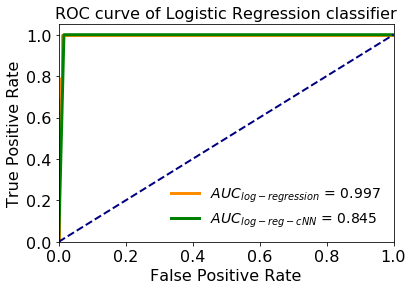

In [93]:
logis= LogisticRegression(random_state=0)
logis.fit(X_res,y_res)
y_pred0logis_rus = logis.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0logis_rus))
print('F1-score %s' % f1_score(y_test, y_pred0logis_rus, average=None))
print(classification_report(y_test, y_pred0logis_rus))

y_scorelogis_rus = logis.predict_proba(X_test)
fpr_logis_rus, tpr_logis_rus, _ = roc_curve(y_test, y_scorelogis_rus[:, 1])
roc_auc_logis_rus = auc(fpr_logis_rus, tpr_logis_rus) 

plt.plot(fpr_logis, tpr_logis, color='darkorange', lw=3, label='$AUC_{log-regression}$ = %.3f' % (roc_auc_logis))
plt.plot(fpr_tree_rus, tpr_tree_rus, color='green', lw=3, label='$AUC_{log-reg-cNN}$ = %.3f' % (roc_auc_logis_rus))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Logistic Regression classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9640993529534544
F1-score [0.98158458 0.2892562 ]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4743
           1       0.18      0.73      0.29        48

    accuracy                           0.96      4791
   macro avg       0.59      0.85      0.64      4791
weighted avg       0.99      0.96      0.97      4791



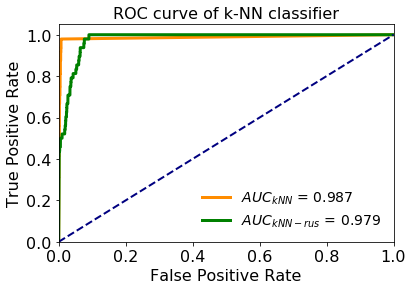

In [94]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_res, y_res)
y_pred0knn_rus = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0knn_rus))
print('F1-score %s' % f1_score(y_test, y_pred0knn_rus, average=None))
print(classification_report(y_test, y_pred0knn_rus))

y_scoreknn_rus = knn.predict_proba(X_test)
fpr_knn_rus, tpr_knn_rus, _ = roc_curve(y_test, y_scoreknn_rus[:, 1])
roc_auc_knn_rus = auc(fpr_knn_rus, tpr_knn_rus)

plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=3, label='$AUC_{kNN}$ = %.3f' % (roc_auc_knn))
plt.plot(fpr_knn_rus, tpr_knn_rus, color='green', lw=3, label='$AUC_{kNN-rus}$ = %.3f' % (roc_auc_knn_rus))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of k-NN classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9273638071383845
F1-score [0.96195058 0.20183486]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      4743
           1       0.11      0.92      0.20        48

    accuracy                           0.93      4791
   macro avg       0.56      0.92      0.58      4791
weighted avg       0.99      0.93      0.95      4791



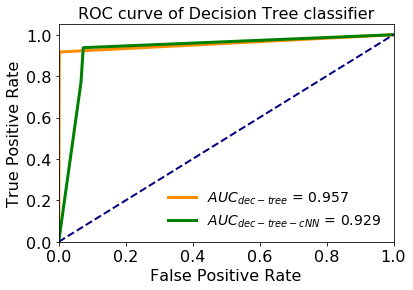

In [95]:
tree=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree.fit(X_res,y_res)
y_pred0tree_rus = tree.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0tree_rus))
print('F1-score %s' % f1_score(y_test, y_pred0tree_rus, average=None))
print(classification_report(y_test, y_pred0tree_rus))

y_scoretree_rus = tree.predict_proba(X_test)
fpr_tree_rus, tpr_tree_rus, _ = roc_curve(y_test, y_scoretree_rus[:, 1])
roc_auc_tree_rus = auc(fpr_tree_rus, tpr_tree_rus) 

plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=3, label='$AUC_{dec-tree}$ = %.3f' % (roc_auc_tree))
plt.plot(fpr_tree_rus, tpr_tree_rus, color='green', lw=3, label='$AUC_{dec-tree-cNN}$ = %.3f' % (roc_auc_tree_rus))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Decision Tree classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

log, dec tree e naive peggiorano la perfomrance con cNN.kNN migliora la performance rispetto al caso base ma con random undersmpling migliorava di piu.

## OVERSAMPLING

In [107]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

RANDOM OVERSAMPLING

In [108]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 11067, 1: 11067})


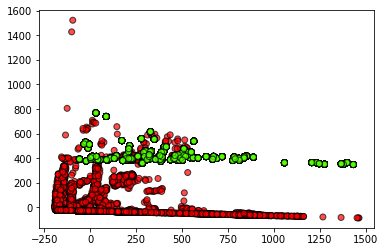

In [109]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9668127739511584
F1-score [0.98295272 0.37647059]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4743
           1       0.23      1.00      0.38        48

    accuracy                           0.97      4791
   macro avg       0.62      0.98      0.68      4791
weighted avg       0.99      0.97      0.98      4791



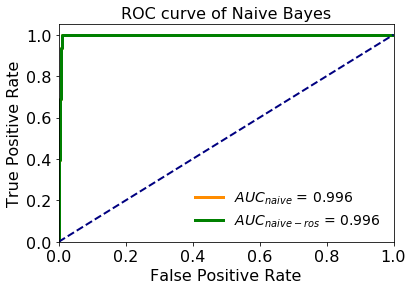

In [110]:
naive = GaussianNB()
naive.fit(X_res, y_res)
y_pred0naive_ros = naive.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0naive_ros))
print('F1-score %s' % f1_score(y_test, y_pred0naive_ros, average=None))
print(classification_report(y_test, y_pred0naive_ros))

y_scorenaive_ros = naive.predict_proba(X_test)
fpr_naive_ros, tpr_naive_ros, _ = roc_curve(y_test, y_scorenaive_ros[:, 1])
roc_auc_naive_ros = auc(fpr_naive_ros, tpr_naive_ros)

plt.plot(fpr_naive, tpr_naive, color='darkorange', lw=3, label='$AUC_{naive}$ = %.3f' % (roc_auc_naive))
plt.plot(fpr_naive_ros, tpr_naive_ros, color='green', lw=3, label='$AUC_{naive-ros}$ = %.3f' % (roc_auc_naive_ros))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Naive Bayes', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9943644333124608
F1-score [0.99714799 0.76521739]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4743
           1       0.66      0.92      0.77        48

    accuracy                           0.99      4791
   macro avg       0.83      0.96      0.88      4791
weighted avg       1.00      0.99      0.99      4791



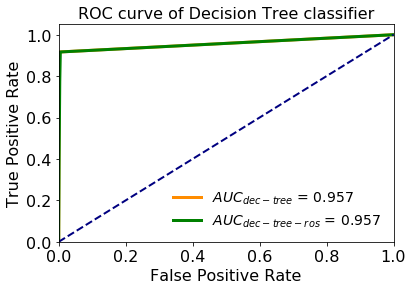

In [111]:
tree=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree.fit(X_res,y_res)
y_pred0tree_ros = tree.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0tree_ros))
print('F1-score %s' % f1_score(y_test, y_pred0tree_ros, average=None))
print(classification_report(y_test, y_pred0tree_ros))

y_scoretree_ros = tree.predict_proba(X_test)
fpr_tree_ros, tpr_tree_ros, _ = roc_curve(y_test, y_scoretree_ros[:, 1])
roc_auc_tree_ros = auc(fpr_tree_ros, tpr_tree_ros) 

plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=3, label='$AUC_{dec-tree}$ = %.3f' % (roc_auc_tree))
plt.plot(fpr_tree_ros, tpr_tree_ros, color='green', lw=3, label='$AUC_{dec-tree-ros}$ = %.3f' % (roc_auc_tree_ros))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Decision Tree classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9897724900855771
F1-score [0.99480767 0.66206897]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.49      1.00      0.66        48

    accuracy                           0.99      4791
   macro avg       0.75      0.99      0.83      4791
weighted avg       0.99      0.99      0.99      4791



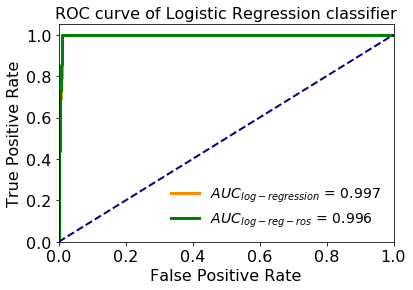

In [112]:
logis= LogisticRegression(random_state=0)
logis.fit(X_res,y_res)
y_pred0logis_ros = logis.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0logis_ros))
print('F1-score %s' % f1_score(y_test, y_pred0logis_ros, average=None))
print(classification_report(y_test, y_pred0logis_ros))

y_scorelogis_ros = logis.predict_proba(X_test)
fpr_logis_ros, tpr_logis_ros, _ = roc_curve(y_test, y_scorelogis_ros[:, 1])
roc_auc_logis_ros = auc(fpr_logis_ros, tpr_logis_ros) 

plt.plot(fpr_logis, tpr_logis, color='darkorange', lw=3, label='$AUC_{log-regression}$ = %.3f' % (roc_auc_logis))
plt.plot(fpr_logis_ros, tpr_logis_ros, color='green', lw=3, label='$AUC_{log-reg-ros}$ = %.3f' % (roc_auc_logis_ros))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Logistic Regression classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9943644333124608
F1-score [0.9971504  0.74766355]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4743
           1       0.68      0.83      0.75        48

    accuracy                           0.99      4791
   macro avg       0.84      0.91      0.87      4791
weighted avg       1.00      0.99      0.99      4791



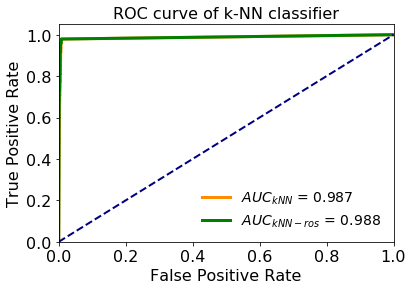

In [113]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_res, y_res)
y_pred0knn_ros = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0knn_ros))
print('F1-score %s' % f1_score(y_test, y_pred0knn_ros, average=None))
print(classification_report(y_test, y_pred0knn_ros))

y_scoreknn_ros = knn.predict_proba(X_test)
fpr_knn_ros, tpr_knn_ros, _ = roc_curve(y_test, y_scoreknn_ros[:, 1])
roc_auc_knn_ros = auc(fpr_knn_ros, tpr_knn_ros)

plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=3, label='$AUC_{kNN}$ = %.3f' % (roc_auc_knn))
plt.plot(fpr_knn_ros, tpr_knn_ros, color='green', lw=3, label='$AUC_{kNN-ros}$ = %.3f' % (roc_auc_knn_ros))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of k-NN classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

SMOTE

In [114]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 11067, 1: 11067})


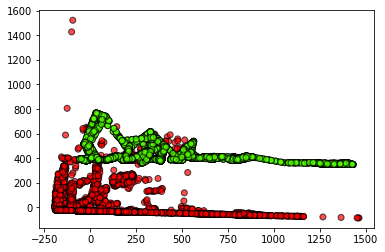

In [115]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

valuto i classificatori

Accuracy 0.9935295345439366
F1-score [0.99672408 0.7394958 ]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.62      0.92      0.74        48

    accuracy                           0.99      4791
   macro avg       0.81      0.96      0.87      4791
weighted avg       1.00      0.99      0.99      4791



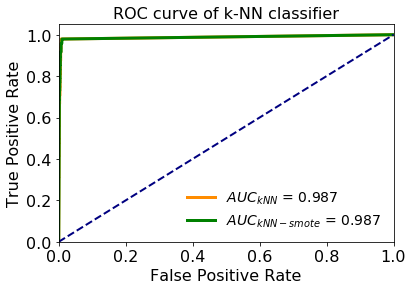

In [116]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_res, y_res)
y_pred0knn_smote = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0knn_smote))
print('F1-score %s' % f1_score(y_test, y_pred0knn_smote, average=None))
print(classification_report(y_test, y_pred0knn_smote))

y_scoreknn_smote = knn.predict_proba(X_test)
fpr_knn_smote, tpr_knn_smote, _ = roc_curve(y_test, y_scoreknn_smote[:, 1])
roc_auc_knn_smote = auc(fpr_knn_smote, tpr_knn_smote)

plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=3, label='$AUC_{kNN}$ = %.3f' % (roc_auc_knn))
plt.plot(fpr_knn_smote, tpr_knn_smote, color='green', lw=3, label='$AUC_{kNN-smote}$ = %.3f' % (roc_auc_knn_smote))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of k-NN classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9891463160091839
F1-score [0.99448802 0.64864865]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.48      1.00      0.65        48

    accuracy                           0.99      4791
   macro avg       0.74      0.99      0.82      4791
weighted avg       0.99      0.99      0.99      4791



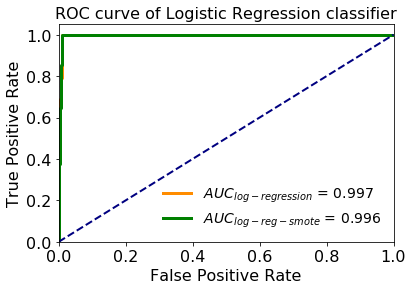

In [119]:
logis= LogisticRegression(random_state=0)
logis.fit(X_res,y_res)
y_pred0logis_smote = logis.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0logis_smote))
print('F1-score %s' % f1_score(y_test, y_pred0logis_smote, average=None))
print(classification_report(y_test, y_pred0logis_smote))

y_scorelogis_smote = logis.predict_proba(X_test)
fpr_logis_smote, tpr_logis_smote, _ = roc_curve(y_test, y_scorelogis_smote[:, 1])
roc_auc_logis_smote = auc(fpr_logis_smote, tpr_logis_smote) 

plt.plot(fpr_logis, tpr_logis, color='darkorange', lw=3, label='$AUC_{log-regression}$ = %.3f' % (roc_auc_logis))
plt.plot(fpr_logis_smote, tpr_logis_smote, color='green', lw=3, label='$AUC_{log-reg-smote}$ = %.3f' % (roc_auc_logis_smote))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Logistic Regression classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9937382592360676
F1-score [0.99682875 0.75409836]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.62      0.96      0.75        48

    accuracy                           0.99      4791
   macro avg       0.81      0.98      0.88      4791
weighted avg       1.00      0.99      0.99      4791



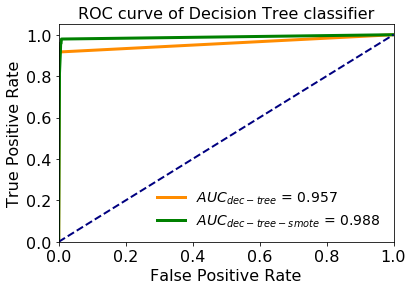

In [120]:
tree=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree.fit(X_res,y_res)
y_pred0tree_smote = tree.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0tree_smote))
print('F1-score %s' % f1_score(y_test, y_pred0tree_smote, average=None))
print(classification_report(y_test, y_pred0tree_smote))

y_scoretree_smote = tree.predict_proba(X_test)
fpr_tree_smote, tpr_tree_smote, _ = roc_curve(y_test, y_scoretree_smote[:, 1])
roc_auc_tree_smote = auc(fpr_tree_smote, tpr_tree_smote) 

plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=3, label='$AUC_{dec-tree}$ = %.3f' % (roc_auc_tree))
plt.plot(fpr_tree_smote, tpr_tree_smote, color='green', lw=3, label='$AUC_{dec-tree-smote}$ = %.3f' % (roc_auc_tree_smote))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Decision Tree classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9741181381757462
F1-score [0.98675497 0.43636364]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      4743
           1       0.28      1.00      0.44        48

    accuracy                           0.97      4791
   macro avg       0.64      0.99      0.71      4791
weighted avg       0.99      0.97      0.98      4791



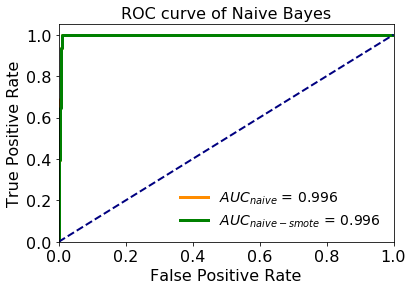

In [121]:
naive = GaussianNB()
naive.fit(X_res, y_res)
y_pred0naive_smote = naive.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0naive_smote))
print('F1-score %s' % f1_score(y_test, y_pred0naive_smote, average=None))
print(classification_report(y_test, y_pred0naive_smote))

y_scorenaive_smote = naive.predict_proba(X_test)
fpr_naive_smote, tpr_naive_smote, _ = roc_curve(y_test, y_scorenaive_smote[:, 1])
roc_auc_naive_smote = auc(fpr_naive_smote, tpr_naive_smote)

plt.plot(fpr_naive, tpr_naive, color='darkorange', lw=3, label='$AUC_{naive}$ = %.3f' % (roc_auc_naive))
plt.plot(fpr_naive_smote, tpr_naive_smote, color='green', lw=3, label='$AUC_{naive-smote}$ = %.3f' % (roc_auc_naive_smote))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Naive Bayes', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## Class weight

Accuracy 0.9956167814652473
F1-score [0.99778411 0.8       ]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4743
           1       0.74      0.88      0.80        48

    accuracy                           1.00      4791
   macro avg       0.87      0.94      0.90      4791
weighted avg       1.00      1.00      1.00      4791



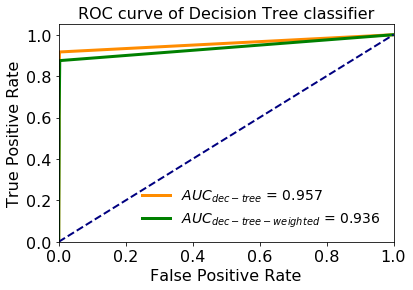

In [132]:
tree=DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0:1, 1: 20}, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree.fit(X_train,y_train)
y_pred0tree_weighted = tree.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0tree_weighted))
print('F1-score %s' % f1_score(y_test, y_pred0tree_weighted, average=None))
print(classification_report(y_test, y_pred0tree_weighted))

y_scoretree_weighted = tree.predict_proba(X_test)
fpr_tree_weighted, tpr_tree_weighted, _ = roc_curve(y_test, y_scoretree_weighted[:, 1])
roc_auc_tree_weighted = auc(fpr_tree_weighted, tpr_tree_weighted) 

plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=3, label='$AUC_{dec-tree}$ = %.3f' % (roc_auc_tree))
plt.plot(fpr_tree_weighted, tpr_tree_weighted, color='green', lw=3, label='$AUC_{dec-tree-weighted}$ = %.3f' % (roc_auc_tree_weighted))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Decision Tree classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9901899394698392
F1-score [0.99502066 0.67132867]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.51      1.00      0.67        48

    accuracy                           0.99      4791
   macro avg       0.75      1.00      0.83      4791
weighted avg       1.00      0.99      0.99      4791



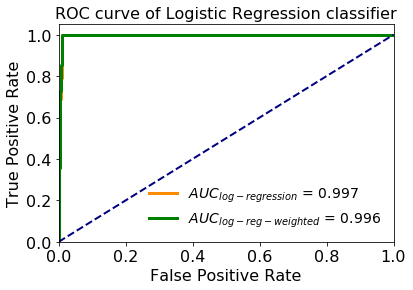

In [138]:
logis= LogisticRegression(random_state=0,class_weight={0:1, 1: 30})
logis.fit(X_train,y_train)
y_pred0logis_weighted = logis.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0logis_weighted))
print('F1-score %s' % f1_score(y_test, y_pred0logis_weighted, average=None))
print(classification_report(y_test, y_pred0logis_weighted))

y_scorelogis_weighted = logis.predict_proba(X_test)
fpr_logis_weighted, tpr_logis_weighted, _ = roc_curve(y_test, y_scorelogis_weighted[:, 1])
roc_auc_logis_weighted = auc(fpr_logis_weighted, tpr_logis_weighted) 

plt.plot(fpr_logis, tpr_logis, color='darkorange', lw=3, label='$AUC_{log-regression}$ = %.3f' % (roc_auc_logis))
plt.plot(fpr_logis_weighted, tpr_logis_weighted, color='green', lw=3, label='$AUC_{log-reg-weighted}$ = %.3f' % (roc_auc_logis_weighted))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Logistic Regression classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

class weighted si puo fare solo per log reg e dec tree, ma in entrambi i casi non ho miglioramenti valutando diversi pesi

#### Meta-cost sensitive classifier

In [146]:
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.metrics import savings_score

ModuleNotFoundError: No module named 'sklearn.cross_validation'